# Optogenetic stimulation

How to inject an optogenetic intervention (opsin and optic fiber) into a simulation.

Preamble:

In [1]:
from brian2 import *
import matplotlib.pyplot as plt

import cleosim
from cleosim import *

cleosim.utilities.style_plots_for_docs()

# numpy faster than cython for lightweight example
prefs.codegen.target = 'numpy'
# for reproducibility
np.random.seed(1866)

INFO       Cache size for target 'cython': 1933664869 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the '/home/kyle/.cython/brian_extensions' directory. [brian2]


## Create a Markov opsin-compatible network
Cleo enables two basic approaches to modeling opsin currents. One is a fairly accurate Markov state model and the other is a simple proportional current model. We will look at the Markov model first.

The established Markov opsin models (as presented in [Evans et al., 2016](https://www.frontiersin.org/articles/10.3389/fninf.2016.00008/full)), are conductance-based and so depend on somewhat realistic membrane voltages.
Note that we follow the conventions used in neuron modeling, where current is positive, rather than the conventions in opsin modeling, where the photocurrent is negative.

We'll use a small neuron group, biased by Poisson input spikes.

In [2]:
n = 10
ng = NeuronGroup(
    n,
    """
    dv/dt = (-(v - E_L) + Delta_T*exp((v-theta)/Delta_T) + Rm*I) / tau_m : volt
    I : amp
    """,
    threshold="v>30*mV",
    reset="v=-55*mV",
    namespace={
        "tau_m": 20 * ms,
        "Rm": 500 * Mohm,
        "theta": -50 * mV,
        "Delta_T": 2 * mV,
        "E_L": -70*mV,
    },
)
ng.v = -70 * mV

input_group = PoissonInput(ng, "v", n, 100 * Hz, 1 * mV)

mon = SpikeMonitor(ng)

net = Network(ng, input_group, mon)
ng.equations

dv/dt = (Delta_T*exp((-theta + v)/Delta_T) + E_L + I*Rm - v)/tau_m : volt
I : amp


## Assign coordinates and configure optogenetic model
The `OptogeneticIntervention` class implements the chosen opsin kinetics model with specified parameters. A standard four-state Markov model as well as channelrhodopsin-2 (ChR2) parameters are included with cleosim and are accessible in the `cleosim.opto` module. For extending to other models (such as three-state or six-state), see the [source code](https://github.com/kjohnsen/cleosim/blob/master/cleosim/opto.py)&mdash;the state equations, opsin-specific parameters, and light wavelength-specific parameters (if not using 473-nm blue) would be needed.

For reference, cleosim draws heavily on [Foutz et al., 2012](https://journals.physiology.org/doi/full/10.1152/jn.00501.2011) for the light propagation model and on [Evans et al., 2016](https://www.frontiersin.org/articles/10.3389/fninf.2016.00008/full) for the opsin kinetics model.

(<Figure size 432x288 with 1 Axes>,
 <Axes3DSubplot:xlabel='x (mm)', ylabel='y (mm)'>)

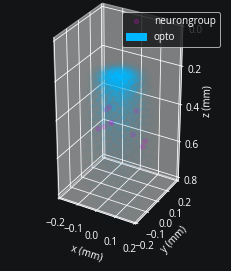

In [3]:
from cleosim.coordinates import assign_coords_rand_rect_prism
from cleosim.opto import *

assign_coords_rand_rect_prism(ng, xlim=(-0.1, 0.1), ylim=(-0.1, 0.1), zlim=(0.4, 0.6))

opto = OptogeneticIntervention(
    name="opto",
    opsin_model=FourStateModel(ChR2_four_state),
    light_model_params=default_blue,
    location=(0, 0, 0.2) * mm,
)

cleosim.visualization.plot(
    ng,
    colors=["xkcd:fuchsia"],
    xlim=(-0.2, 0.2),
    ylim=(-0.2, 0.2),
    zlim=(0, 0.8),
    devices=[(opto, {'n_points': 3e4, 'intensity': 1})],  # num points to visualize
)

## Open-loop optogenetic stimulation
We need to inject our optogenetic intervention into the simulator. `cleosim` handles all the object creation and equations needed to interact with the existing Brian model without the need to alter it, with the possible exception of adding a variable to represent the opsin current. This needs to be specified upon injection with `Iopto_var_name=...` if not the default `Iopto`. The membrane potential variable name also needs to be specified (with `v_var_name=...`) if not the default `v`.

In [4]:
sim = CLSimulator(net)
sim.inject_stimulator(opto, ng, Iopto_var_name='I')

### IO processor setup

Here we design an IO processor that ignores measurements and simply sets the light intensity according to the `stimulus(t)` function:

In [5]:
from cleosim.processing import LatencyIOProcessor

def stimulus(time_ms):
    f = 30
    return 1 * (1 + np.sin(2*np.pi*f * time_ms/1000))

class OpenLoopOpto(LatencyIOProcessor):
    def __init__(self):
        super().__init__(sample_period_ms=1)

    # since this is open-loop, we don't use state_dict
    def process(self, state_dict, time_ms):
        opto_intensity = stimulus(time_ms)
        # return output dict and time
        return ({"opto": opto_intensity}, time_ms)

sim.set_io_processor(OpenLoopOpto())

### Run simulation and plot results

INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]


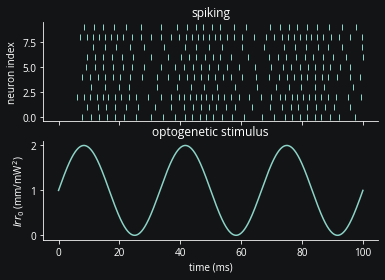

In [6]:
sim.run(100*ms)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(mon.t / ms, mon.i[:], '|')
ax1.set(ylabel='neuron index', title='spiking')
t_sim=np.linspace(0, 100, 1000)
ax2.plot(t_sim, stimulus(t_sim))
ax2.set(ylabel=r'$Irr_0$ (mm/mW$^2$)', title='optogenetic stimulus', xlabel='time (ms)');

## Conclusion
We can see clearly that firing rate correlates with light intensity as expected.

As a recap, in this tutorial we've seen how to:
* configure an `OptogeneticIntervention`,
* inject it into the simulation,
* and control its light intensity in an open-loop fashion.

## Appendix: alternative opsin and neuron models

Because it would be a pain and an obstacle to reproducibility to have to replace all pre-existing simple neuron models with more sophisticated ones with proper voltage ranges and units, we provide an approximation that is much more flexible, requiring only a current term, of any unit, in the target neurons. 

The Markov models of opsin dynamics we've used so far produce a rise, peak, and fall to a steady-state plateau current when subjected to sustained light. Since they are conductance-based, the current also varies with membrane voltage, including during spikes.
The `ProportionalCurrentModel`, on the other hand, simply delivers current proportional to light intensity. 
This should be adequate for a wide range of use cases where the exact opsin current dynamics on short timescales don't matter so much and a sort of average current-light relationship will suffice.

Speaking of realistic membrane voltages, does the Markov model's voltage-dependent current render it unsuitable for the most basic leaky integrate-and-fire (LIF) neuron model? LIF neurons reset on reaching their rheobase threshold, staying perpetually in a subthreshold region producing exaggerated opsin currents. How much does this affect the output? We will explore this question by comparing a variety of opsin/neuron model combinations.

First, we introduce exponential integrate-and-fire neurons, which maintain simplicity while modeling an upward membrane potential swing during a spike. For more info, see the [related section in the Neuronal Dynamics online textbook](https://neuronaldynamics.epfl.ch/online/Ch5.S2.html) and their [example parameters table](https://neuronaldynamics.epfl.ch/online/Ch6.S2.html#:~:text=Table%C2%A06.1%3A%20Exemplar%20parameters).


In [7]:
neuron_params = {
    "tau_m": 20 * ms,
    "Rm": 500 * Mohm,
    "theta": -50 * mV,
    "Delta_T": 2 * mV,
    "E_L": -70*mV,
}

def prep_ng(ng, neuron_type, markov_opsin):
    ng.v = neuron_params['E_L']
    assign_coords_rand_rect_prism(ng, xlim=(0, 0), ylim=(0, 0), zlim=(0, 0))
    state_mon = StateMonitor(ng,("Iopto", "v"), record=True)
    spike_mon = SpikeMonitor(ng)
    return neuron_type, ng, state_mon, spike_mon, markov_opsin

experiments = []

eif = NeuronGroup(
    1,
    """
    dv/dt = (-(v - E_L) + Delta_T*exp((v-theta)/Delta_T) + Rm*Iopto) / tau_m : volt
    Iopto : amp
    """,
    threshold="v > -10*mV",
    reset="v = E_L - 0*mV",
    namespace=neuron_params,
)

experiments.append(prep_ng(eif, 'EIF', True))

### Configure LIF models
Here we define LIF neurons with biological parameters for the sake of comparison, but the `ProportionalCurrentModel` is compatible with models of any voltage range and units, so long as it has an `Iopto` term.

In [8]:
def prep_lif(markov_opsin):
    ng = NeuronGroup(
        1,
        """dv/dt = (-(v - E_L) + Rm*Iopto) / tau_m : volt
        Iopto : amp""",
        threshold="v > theta + 4*mV",
        reset="v = E_L - 0*mV",
        namespace=neuron_params,
    )
    return prep_ng(ng, "LIF", markov_opsin)

experiments.append(prep_lif(True))
experiments.append(prep_lif(False))

### Comparing to more realistic models
To see how well simplified neuron and opsin models do, we'll also compare to the more complex [AdEx neuron](http://www.scholarpedia.org/article/Adaptive_exponential_integrate-and-fire_model#:~:text=The%20Adaptive%20exponential%20integrate-and-fire%20model%2C%20also%20called%20AdEx%2C,coupled%20to%20a%20second%20equation%20which%20describes%20adaptation.) (with ["tonic" firing pattern parameters](https://neuronaldynamics.epfl.ch/online/Ch6.S2.html)) and a Hodgkin-Huxley model (code from [Neuronal Dynamics](https://neuronaldynamics-exercises.readthedocs.io/en/latest/_modules/neurodynex3/hodgkin_huxley/HH.html#:~:text=def%20simulate_HH_neuron)).

In [9]:
adex = NeuronGroup(
    1,
    """dv/dt = (-(v - E_L) + 2*mV*exp((v-theta)/Delta_T) + Rm*(Iopto-w)) / tau_m : volt
    dw/dt = (0*nsiemens*(v-E_L) - w) / (100*ms) : amp
    Iopto : amp""",
    threshold="v>=-10*mV",
    reset="v=-55*mV; w+=5*pamp",
    namespace=neuron_params,
)
experiments.append(prep_ng(adex, "AdEx", True))

# Parameters
# Cm = 1*ufarad*cm**-2 * area
Cm = neuron_params["tau_m"] / neuron_params["Rm"]
# area = 5000*umetre**2
area = Cm / (1*ufarad*cm**-2)
gl = 0.3*msiemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 40*msiemens*cm**-2 * area
g_kd = 35*msiemens*cm**-2 * area
VT = -63*mV

# The model
eqs = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + Iopto)/Cm : volt
dm/dt = 0.32*(mV**-1)*4*mV/exprel((13.*mV-v+VT)/(4*mV))/ms*(1-m)-0.28*(mV**-1)*5*mV/exprel((v-VT-40.*mV)/(5*mV))/ms*m : 1
dn/dt = 0.032*(mV**-1)*5*mV/exprel((15.*mV-v+VT)/(5*mV))/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
Iopto : amp
''')
# Threshold and refractoriness are only used for spike counting
hh = NeuronGroup(1, eqs,
                 threshold='v > -40*mV',
                 reset='',
                 method='exponential_euler')

experiments.append(prep_ng(hh, "HH", True))

### Opsin configuration
Note that the only parameter we need to set for the simple opsin model is the gain on light intensity, `Iopto_per_mW_per_mm2`.
This term defines what the neuron receives for every 1 mW/mm2 of light intensity.
Here that term is defined in amperes, but it could have been unitless for a simpler model.

The gain is tuned somewhat by hand (in relation to the membrane resistance and the 20 mV gap between rest and threshold potential) to achieve similar outputs to the Markov model.

In [10]:
simple_opto = OptogeneticIntervention(
    name="simple_opto",
    # handpicked gain to make firing rate roughly comparable to EIF
    opsin_model=ProportionalCurrentModel(Iopto_per_mW_per_mm2=240/neuron_params['Rm']*20*mV),
    light_model_params=default_blue,
)

markov_opto = OptogeneticIntervention(
    name="markov_opto",
    opsin_model=FourStateModel(ChR2_four_state),
    light_model_params=default_blue,
)

### Simulation

And we set up the simulator:

In [11]:
net = Network()
sim = CLSimulator(net)
for ng_type, ng, state_mon, spike_mon, markov_opsin in experiments:
    net.add(ng, state_mon, spike_mon)
    if markov_opsin:
        sim.inject_stimulator(markov_opto, ng)
    else:
        sim.inject_stimulator(simple_opto, ng)

We'll now run the simulation with light pulses of increasing amplitudes to observe the effect on the current.

In [12]:
# hand-picked range of amplitudes to show 0 to moderate firing rates
for Irr0_mW_per_mm2 in np.linspace(0.005, 0.03, 5):
    markov_opto.update(Irr0_mW_per_mm2)
    simple_opto.update(Irr0_mW_per_mm2)
    sim.run(60 * ms)
    markov_opto.update(0)
    simple_opto.update(0)
    sim.run(60 * ms)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.01s, trying other methods took 0.04s). [brian2.stateupdaters.base.method_choice]


INFO       No numerical integration method specified for group 'neurongroup_2', using method 'exact' (took 0.04s). [brian2.stateupdaters.base.method_choice]


INFO       No numerical integration method specified for group 'neurongroup_3', using method 'exact' (took 0.02s). [brian2.stateupdaters.base.method_choice]


INFO       No numerical integration method specified for group 'neurongroup_4', using method 'euler' (took 0.01s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]


WARNING    'n' is an internal variable of group 'neurongroup_5', but also exists in the run namespace with the value 10. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


### Results

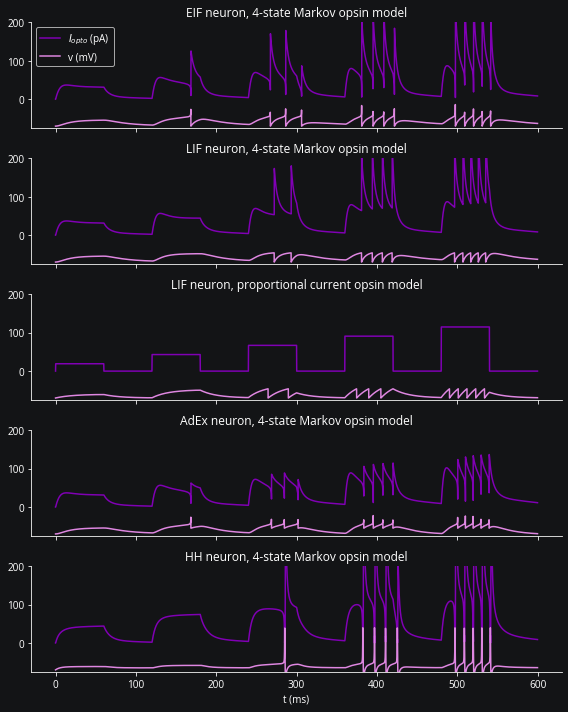

In [13]:
c1 = '#8000b4'
c2 = '#df87e1'

fig, axs = plt.subplots(
    len(experiments), 1, figsize=(8, 2*len(experiments)), sharex=True
)

for ax, (ng_type, _, state_mon, spike_mon, markov_opsin) in zip(axs, experiments):
    ax.plot(state_mon.t / ms, state_mon.Iopto[0] / pamp, c=c1, label="$I_{opto}$ (pA)")
    ax.plot(state_mon.t / ms, state_mon.v[0] / mV, c=c2, label="v (mV)")
    opsin_name = "4-state Markov" if markov_opsin else "proportional current"
    ax.set(title=f"{ng_type} neuron, {opsin_name} opsin model")

axs[-1].set_xlabel('t (ms)')
axs[0].legend();

max_ylim = max([ax.get_ylim()[1] for ax in axs])
for ax in axs:
    ax.set_ylim([-75, 200])

fig.tight_layout()

Qualitatively we can see that the proportional current model doesn't capture the rise, peak, plateau, and fall dynamics that a Markov model can produce, but is a reasonable approximation if all you need is a roughly linear light intensity-firing rate relationship. We also see that a variety of neuron/opsin model combinations all produce similar firing responses to light.